Training Accuracy: 0.72
Testing Accuracy: 0.64


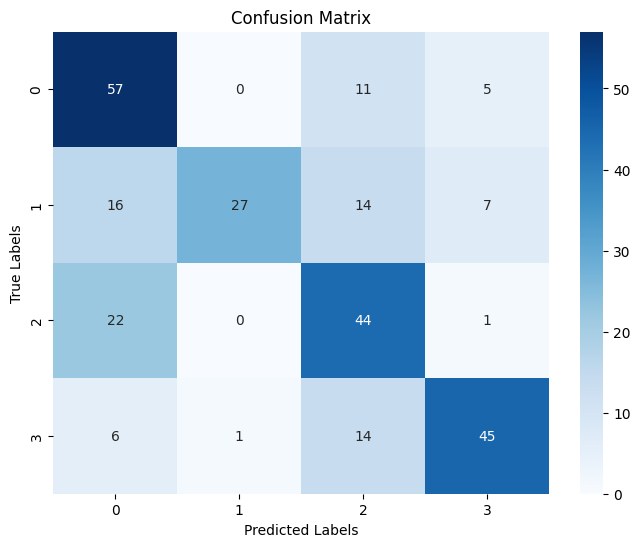

False Negative Rate for Class 0: 0.22
False Negative Rate for Class 1: 0.58
False Negative Rate for Class 2: 0.34
False Negative Rate for Class 3: 0.32

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.78      0.66        73
           1       0.96      0.42      0.59        64
           2       0.53      0.66      0.59        67
           3       0.78      0.68      0.73        66

    accuracy                           0.64       270
   macro avg       0.71      0.64      0.64       270
weighted avg       0.70      0.64      0.64       270



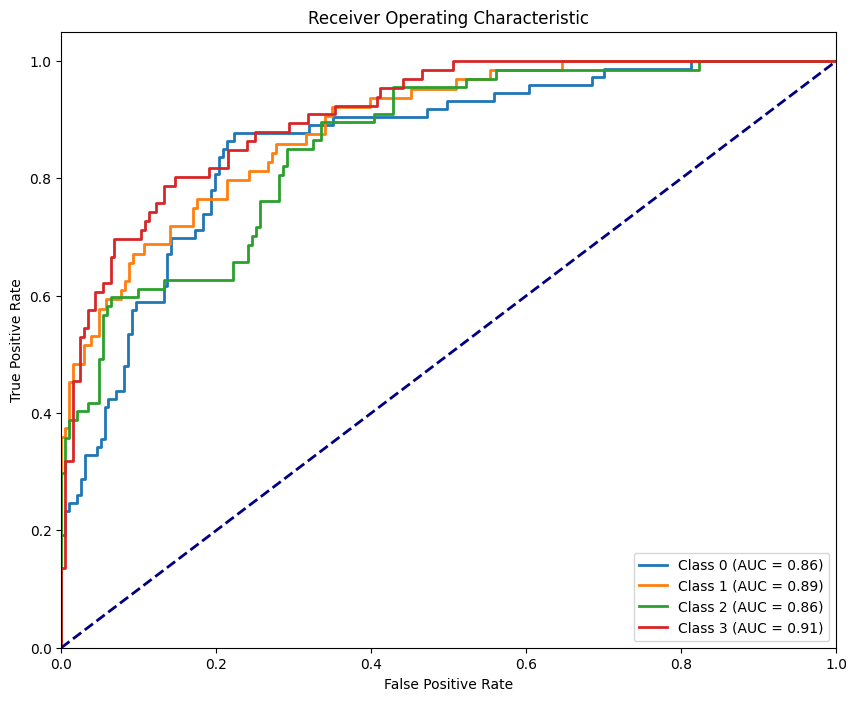

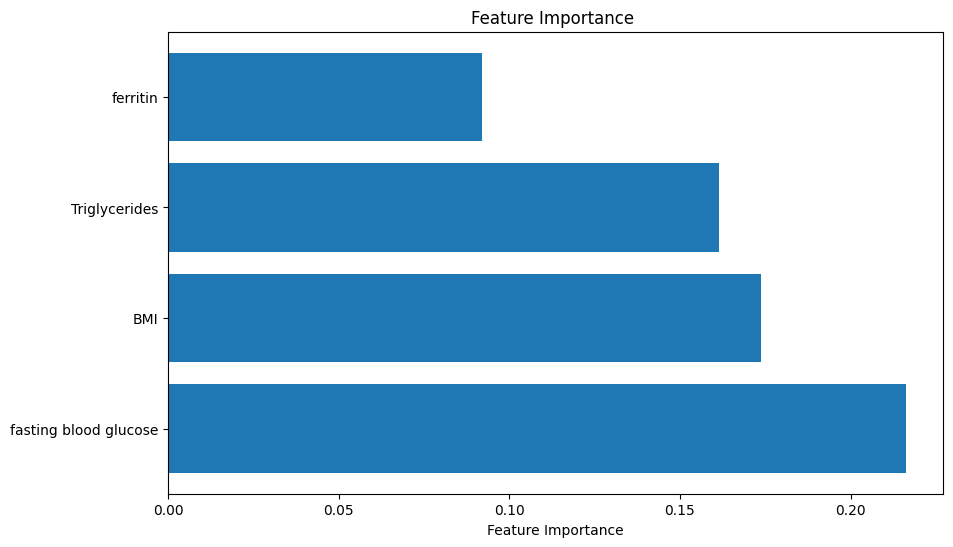

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Load training dataset
data = pd.read_excel('/content/7features_f_4del.xlsx')
data = data.drop(columns=['Creatinine','Alkaline phosphatase','INR','Platelets'])
data.fillna(data.mean(numeric_only=True), inplace=True)

# Load external test dataset
test_data_from_file = pd.read_excel('/content/test_7features_f_4del.xlsx')
test_data_from_file = test_data_from_file.drop(columns=['Creatinine','Alkaline phosphatase','INR','Platelets'])
test_data_from_file.fillna(test_data_from_file.mean(numeric_only=True), inplace=True)


# Splitting features and target
X = data.drop('steato score', axis=1)
y = data['steato score']

# Split the data into training and internal testing sets
X_train, X_test_temp, y_train, y_test_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine internal test and external test data
X_test_combined = pd.concat([X_test_temp, test_data_from_file.drop('steato score', axis=1)], axis=0)
y_test_combined = pd.concat([y_test_temp, test_data_from_file['steato score']], axis=0)


# Hyperparameter tuning for RandomForestClassifier with regularization to prevent overfitting
param = {
    'n_estimators': [50, 75],  # Number of trees in the forest
    'max_depth': [3, 5],      # Maximum depth of each tree
    'min_samples_split': [2, 5], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]    # Minimum number of samples required to be at a leaf node
}

# Model initialization
model_rf = RandomForestClassifier(**param, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model_rf, param_grid=param, cv=5)
grid_search.fit(X_train, y_train)

# Best Model selected
model_rf = grid_search.best_estimator_

train_acc = model_rf.score(X_train, y_train)
test_acc = model_rf.score(X_test_combined, y_test_combined)
real_test_acc = model_rf.score(test_data_from_file.drop('steato score', axis=1),test_data_from_file['steato score'])

print(f"Training Accuracy: {train_acc:.2f}")
print(f"Testing Accuracy: {test_acc:.2f}")


# Evaluation on combined test data
y_test_pred_combined_rf = model_rf.predict(X_test_combined)
y_test_prob_combined_rf = model_rf.predict_proba(X_test_combined)

# Confusion Matrix
def plot_confusion_matrix_rf_with_fnr(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate and display False Negative Rate for each class
    fnr_per_class = []
    for i in range(len(classes)):
        fn = cm[i].sum() - cm[i, i]  # False Negatives for class i
        tp = cm[i, i]  # True Positives for class i
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        fnr_per_class.append(fnr)
        print(f"False Negative Rate for Class {classes[i]}: {fnr:.2f}")

# Confusion Matrix
cm_combined_rf = confusion_matrix(y_test_combined, y_test_pred_combined_rf)
plot_confusion_matrix_rf_with_fnr(cm_combined_rf, np.unique(y_test_combined))


# Classification Report
report_rf = classification_report(y_test_combined, y_test_pred_combined_rf, target_names=np.unique(y_test_combined).astype(str))
print("\nClassification Report:\n", report_rf)

# ROC Curve
plt.figure(figsize=(10, 8))
for i, cls in enumerate(model_rf.classes_):
    fpr, tpr, _ = roc_curve((y_test_combined == cls).astype(int), y_test_prob_combined_rf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {cls} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model_rf, X_test_combined, y_test_combined, n_repeats=10, random_state=42)
importance_scores = perm_importance.importances_mean
sorted_idx_perm = np.argsort(importance_scores)[::-1]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(np.array(X.columns)[sorted_idx_perm], importance_scores[sorted_idx_perm])
plt.xlabel('Feature Importance')
plt.title('Feature Importance ')
plt.show()